## Setup

In [1]:
import os
import optuna
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.metrics import f1_score

from src.py_src import util
from src.py_src.models import Specialist910Model

C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

slided_df_path = os.path.join(os.getenv("SLIDED_DFS_CSV_PATH"), "data_slided_V3.parquet")
target_class = 'target_class_in_24h'
target_flux = 'target_flux_in_24h'
target_columns = [target_class, target_flux]

buffer_limits = (8.0e-6, 2.0e-5)

df_model_input = util.create_df_model_input_opt(slided_df_path, target_columns, "xl_")

Carregando 34 colunas do arquivo Parquet...


## Preparing Data

In [3]:
specialist_910_pool = df_model_input[df_model_input[target_class] > 2].copy()

train_pct = 0.7
val_pct = (1-train_pct)/2

data = util.prepare_data(
    df_model_input=specialist_910_pool,
    target_class_col=target_class,
    lambda_function=lambda lb: 1 if lb >= 4 else 0,
    train_pct=train_pct,
    val_pct=val_pct,
    target_flux_col=target_flux
)

## Discovery Model

In [4]:
discovery_model = Specialist910Model(
    params={
        'n_estimators': 300,
        'learning_rate': 0.05,
        'max_depth': 5,
        'n_jobs': -1,
        'random_state': 42
    },
    buffer_limits=buffer_limits
)

In [5]:
selected_features = discovery_model.discover_top_features(
    x=data['x']['train'],
    y=data['y']['train'],
    flux_values=data['flux']['train'],
    cumulative_threshold=0.95
)

--- Quick Scan (Discovery Mode) ---
Quick Scan concluído. 23 features selecionadas (de 32).


## Hyperparameter Tuning (Optuna)

In [6]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': 1000,
        'random_state': 1502,
        'n_jobs': -1,
        'early_stopping_rounds': 50,
        'device': 'cuda',

        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 1.0, 5.0),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = Specialist910Model(params=params, buffer_limits=buffer_limits, features_to_keep=selected_features)

    model.fit(
        x=data['x']['train'],
        y=data['y']['train'],
        flux_values=data['flux']['train'],
        eval_set=[(data['x']['val'], data['y']['val'])],
        verbose=False
    )

    y_pred_val = model.predict_proba(data['x']['val'])[:, 1]

    y_pred_class = (y_pred_val >= 0.5).astype(int)

    return f1_score(data['y']['val'], y_pred_class, average='macro')

In [7]:
study = optuna.create_study(direction='maximize')
print("\nIniciando tuning...")
study.optimize(objective, n_trials=100)

print(f"\nBest Score: {study.best_value:.4f}")
best_params = study.best_params

best_params.update({
    'n_estimators': 1000, 'objective': 'binary:logistic',
    'eval_metric': 'logloss', 'random_state': 1502,
    'n_jobs': -1, 'early_stopping_rounds': 50
})

[I 2025-11-23 15:06:00,216] A new study created in memory with name: no-name-4795f8ce-bbd5-47e5-8f6b-2db78d35b1fc



Iniciando tuning...


C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [15:06:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-11-23 15:06:01,615] Trial 0 finished with value: 0.6555627159896587 and parameters: {'scale_pos_weight': 2.036568971235149, 'max_depth': 8, 'learning_rate': 0.14384337261768068, 'subsample': 0.6514133766911442, 'colsample_bytree': 0.7327002177871929, 'gamma': 2.464081141638492, 'min_child_weight': 8}. Best is trial 0 with value: 0.6555627159896587.
[I 2025-11-23 15:06:03,238] Trial 1 finished w


Best Score: 0.6835


In [8]:
final_model = Specialist910Model(params=study.best_params, buffer_limits=buffer_limits, features_to_keep=selected_features)
final_model.fit(
    x=data['x']['train'], y=data['y']['train'],
    flux_values=data['flux']['train']
)

,params,"{'colsample_bytree': 0.8453768784864577, 'gamma': 1.5611698112402475, 'learning_rate': 0.05702571640438259, 'max_depth': 6, ...}"
,buffer_limits,None
,buffer_weight,0.2
,threshold,0.5
,features_to_keep,"['xl_mean_12h', 'xl_max_1h', ...]"


## Threshold Tuning

In [9]:
fig = final_model.get_threshold_graph(data['x']['test'], data['y']['test'])
plt.show()

In [10]:
final_model.optimize_threshold(data['x']['test'], data['y']['test'])

Threshold de Equilíbrio (P=R): 0.5679


np.float32(0.56790125)

## Results

In [11]:
print(final_model.get_classification_report(
    data['x']['test'], data['y']['test'], target_names=['C', 'MX']
))

              precision    recall  f1-score   support

           C       0.63      0.63      0.63     52860
          MX       0.70      0.70      0.70     66760

    accuracy                           0.67    119620
   macro avg       0.66      0.66      0.66    119620
weighted avg       0.67      0.67      0.67    119620



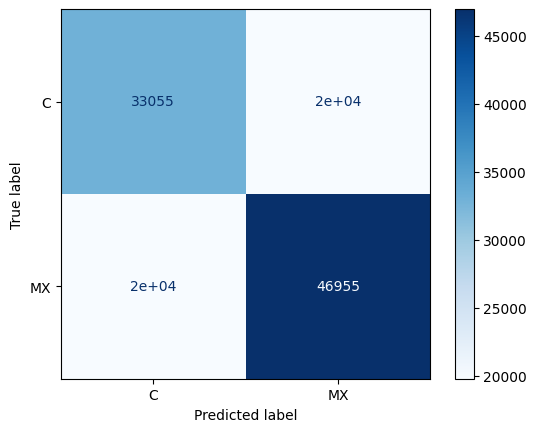

In [12]:
disp = final_model.get_confusion_matrix_display(
    data['x']['test'], data['y']['test'], display_labels=['C', 'MX']
)
disp.plot(cmap='Blues')
plt.show()

In [13]:
fig, summary = final_model.analyze_flux_errors(
    data['x']['test'], data['y']['test'],
    flux_values=data['flux']['test'],
    buffer_limits=buffer_limits
)
display(summary)
plt.show()

Outcome,TN (Correct Rejection),FP (False Alarm),FP Rate (%),TP (Hit),FN (Miss),FN Rate (%)
Zone,,,,,,
1. Safe Zone (Low Flux),29270,14960,33.8,0,0,NaN
2. Buffer Zone,3785,4845,56.1,15885,10194,39.1
3. Safe Zone (High Flux),0,0,NaN,31070,9611,23.6


## Features Importance

In [14]:
features_importance = final_model.get_feature_importance()
features_importance

,feature,importance,cumulative_importance
0,xl_mean_12h,0.202879,0.202879
2,xl_mean_24h,0.124678,0.327557
3,xl_mean_6h,0.107693,0.435250
1,xl_max_1h,0.056648,0.491898
11,xl_std_24h,0.041071,0.532969
7,xl_max_24h,0.036474,0.569443
4,xl_std_1h,0.034580,0.604023
9,xl_max_7D,0.029012,0.633035
5,xl_max_6h,0.028147,0.661182
6,xl_max_14D,0.027876,0.689059


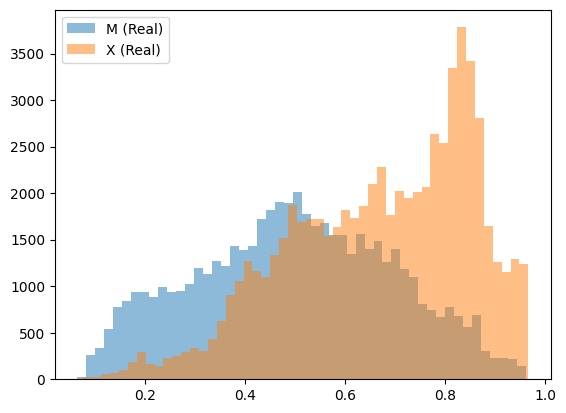

In [15]:
y_proba = final_model.predict_proba(data['x']['test'])[:, 1]
plt.hist(y_proba[data['y']['test']==0], bins=50, alpha=0.5, label='M (Real)')
plt.hist(y_proba[data['y']['test']==1], bins=50, alpha=0.5, label='X (Real)')
plt.legend()
plt.show()

## Export

In [16]:
# save_path = r'../../models/specialist_910/specialist_910_v2_oop.joblib'
# final_model.save(save_path)
